In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions

from pycox.datasets import metabric
from pycox.models import LogisticHazard
from pycox.evaluation import EvalSurv

np.random.seed(1234)
_ = torch.manual_seed(123)

In [2]:
data = pd.read_csv('C:\\Users\\raibe\\Desktop\\Thesis Code\\datasets\\mortgage\\WideFormatMortgageAfterRemovingNull.csv')

In [3]:
data = data.drop(["id", "first_time", "default_time", "status_time", "time"], axis=1)

In [4]:
data.head()

,duration,orig_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,uer_time,REtype_CO_orig_time,REtype_PU_orig_time,REtype_SF_orig_time,investor_orig_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,payoff_time
0,24,-7,113,29087.21,26.658065,9.200,146.45,2.715903,8.3,0,0,1,0,45000.0,715,69.4,9.200,87.03,0
1,2,18,138,105654.77,65.469851,7.680,225.10,2.151365,4.7,0,0,1,0,107200.0,558,80.0,7.680,186.91,1
2,5,-6,114,44378.60,31.459735,11.375,217.37,1.692969,4.5,0,0,1,0,48600.0,680,83.6,8.750,89.58,1
3,36,-2,119,52686.35,34.898842,10.500,189.82,2.836358,5.7,0,0,1,0,63750.0,587,81.8,10.500,97.99,0
4,3,18,138,52100.71,66.346343,9.155,222.39,2.361722,4.4,0,0,1,0,52800.0,527,80.0,9.155,186.91,1


In [5]:
df_train = data
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [6]:
cols_standardize = ['orig_time', 'mat_time', 'balance_time', 'LTV_time', 'interest_rate_time', 'hpi_time', 'gdp_time', 'uer_time', 'balance_orig_time', 
                    'FICO_orig_time', 'LTV_orig_time', 'Interest_Rate_orig_time', 'hpi_orig_time']
cols_leave = ['REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time', 'investor_orig_time']#, 'duration', 'default_time'

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [7]:
num_durations = 25

labtrans = LogisticHazard.label_transform(num_durations)

get_target = lambda df: (df['duration'].values, df['payoff_time'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [8]:
in_features = x_train.shape[1]
num_nodes = [256, 256, 256, 256]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [9]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

C:\Users\raibe\Anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [10]:
batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

In [11]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[1s / 1s],		train_loss: 1.2011,	val_loss: 0.8890
1:	[2s / 3s],		train_loss: 0.8811,	val_loss: 0.8076
2:	[2s / 6s],		train_loss: 0.8399,	val_loss: 0.7728
3:	[2s / 8s],		train_loss: 0.8073,	val_loss: 0.7535
4:	[1s / 10s],		train_loss: 0.7797,	val_loss: 0.6958
5:	[2s / 12s],		train_loss: 0.7528,	val_loss: 0.7199
6:	[2s / 15s],		train_loss: 0.7393,	val_loss: 0.7299
7:	[2s / 17s],		train_loss: 0.7192,	val_loss: 0.6711
8:	[2s / 20s],		train_loss: 0.7159,	val_loss: 0.6566
9:	[2s / 23s],		train_loss: 0.7019,	val_loss: 0.6474
10:	[2s / 25s],		train_loss: 0.6890,	val_loss: 0.6090
11:	[2s / 28s],		train_loss: 0.6832,	val_loss: 0.6325
12:	[2s / 30s],		train_loss: 0.6773,	val_loss: 0.6471
13:	[2s / 33s],		train_loss: 0.6642,	val_loss: 0.6225
14:	[2s / 35s],		train_loss: 0.6645,	val_loss: 0.6086
15:	[2s / 38s],		train_loss: 0.6441,	val_loss: 0.5955
16:	[2s / 40s],		train_loss: 0.6410,	val_loss: 0.5937
17:	[2s / 43s],		train_loss: 0.6361,	val_loss: 0.6391
18:	[2s / 45s],		train_loss: 0.6349,	val_l

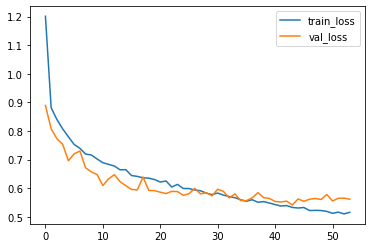

In [12]:
_ = log.plot()

In [13]:
log.to_pandas().val_loss.min()

0.5411251187324524

In [14]:
model.score_in_batches(val)

{'loss': 0.5411251187324524}

In [15]:
surv = model.predict_surv_df(x_test)

In [16]:
surv = model.interpolate(10).predict_surv_df(x_test)

In [17]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [18]:
ev.concordance_td()

0.9177190558309727